In [171]:
# Import all necessary libraries.
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

In [172]:
# Utility functions.
def mod(V):
    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    c_seq = mod(np.array([2,0,3,1]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [173]:
# Number of QPSK symbols to be transmitted.
N = 100000

In [174]:
# Generate different random phases.
M = 129
phase = np.exp(1j*np.pi/np.linspace(2,M,num=512))

phase_rnd = np.zeros((N,1),dtype=np.complex_)
for i in range(0,N):
    phase_rnd[i] = phase[np.random.randint(len(phase))]
    
theta_orig = np.arctan(phase_rnd.real/phase_rnd.imag)

In [175]:
# Define Es/N0 value in dB.
EsN0dB = 30
# Tranform into linear value.
EsN0Lin = 10.0**(-(EsN0dB/10.0))
    
# Generate N binary symbols.
ip = np.random.randint(0,4,(N,1))
    
# Modulate binary stream into QPSK symbols.
s = mod(ip)
    
# Generate noise vector. 
# Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
# Add phase error and pass symbols through AWGN channel.
y = s*phase_rnd + np.sqrt(EsN0Lin)*noise

# Phase of received signal.
theta = np.arctan(y.real/y.imag)

In [176]:
# Split arrays into training and validation subsets.
theta_train, theta_test, theta_orig_train, theta_orig_test, y_train, y_test, ip_train, ip_test, s_train, s_test = train_test_split(theta, theta_orig.ravel(), y, ip, s, test_size=0.2, random_state=1)

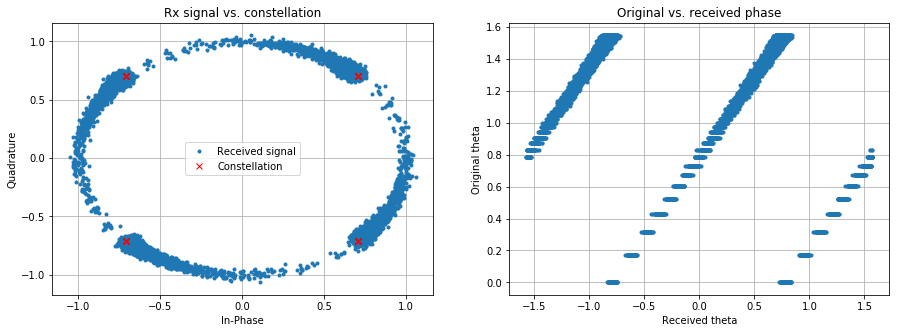

In [177]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1, 2, 1)
plt.plot(y_test.real, y_test.imag,'.', label='Received signal')
plt.plot(s_test.real, s_test.imag,'rx', label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Rx signal vs. constellation')
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(theta,theta_orig,'.')
plt.xlabel('Received theta')
plt.ylabel('Original theta')
plt.title('Original vs. received phase')
plt.grid()

plt.show()

In [161]:
# Instantiate MLP Regressor.
#reg = MLPRegressor(hidden_layer_sizes=(10,4), random_state=1, max_iter=2000) # score: 0.7338
#reg = MLPRegressor(hidden_layer_sizes=(10,5,4,2), random_state=1, max_iter=2000) # score: 0.8144
#reg = MLPRegressor(hidden_layer_sizes=(20,10,5,4,2), random_state=1, max_iter=2000) # score: 0.8066
#reg = MLPRegressor(hidden_layer_sizes=(10,5,2), random_state=1, max_iter=2000) # score: 0.8071
#reg = MLPRegressor(hidden_layer_sizes=(100,70,50,2), random_state=1, max_iter=2000) # score: 0.8218
#reg = MLPRegressor(hidden_layer_sizes=(400,280,200,2), random_state=1, max_iter=2000) # score: 0.8155
#reg = MLPRegressor(hidden_layer_sizes=(200,100,50,2), random_state=1, max_iter=2000) # score: 0.8438
#reg = MLPRegressor(hidden_layer_sizes=(200,100,50,4), random_state=1, max_iter=2000) # score: 0.8447

# Train MLP Regressor.
reg.fit(theta_train, theta_orig_train)

# Print number of training iterations.
print(reg.n_iter_)

# Print score.
print(reg.score(theta_test, theta_orig_test))

24


In [178]:
reg = MLPRegressor(random_state=1, max_iter=2000)

hidden_layer_sizes = [(int(x), int(y), int(z)) for x in np.logspace(start=0, stop=2.5, num=8) for y in np.logspace(start=0, stop=2.5, num=8) for z in np.logspace(start=0, stop=2.5, num=8)]
learning_rate = ['constant', 'invscaling', 'adaptive']

random_grid = {'learning_rate': learning_rate, 'hidden_layer_sizes': hidden_layer_sizes}
reg_random_search = RandomizedSearchCV(estimator=reg, param_distributions=random_grid, cv=5, n_iter=350, n_jobs=-1)

reg_random_search.fit(theta_train, theta_orig_train)

print(reg_random_search.best_estimator_)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 61, 138), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [182]:
# Print score.
print(reg_random_search.score(theta_test, theta_orig_test))

print(reg_random_search.best_params_)

0.8191163298457195
{'learning_rate': 'adaptive', 'hidden_layer_sizes': (5, 61, 138)}


In [147]:
# Predict phase over test set.
theta_pred = reg.predict(theta_test).reshape(len(theta_test), 1)

# Undo phase-shift.
y_rec = np.exp(1j*theta_pred)*y_test

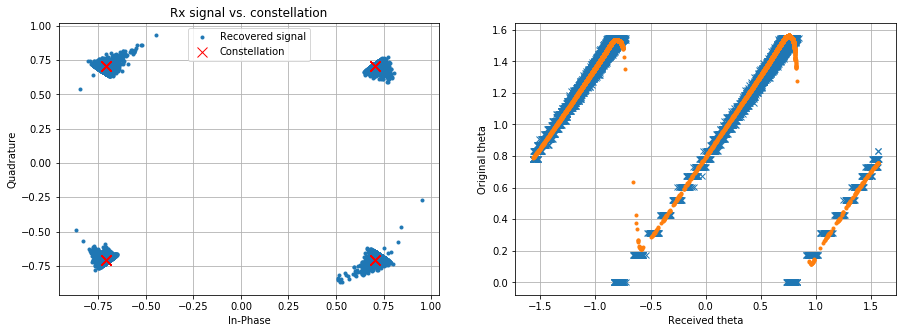

In [148]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1, 2, 1)
plt.plot(y_rec.real, y_rec.imag,'.', label='Recovered signal')
plt.plot(s_test.real, s_test.imag,'rx', markersize=10, label='Constellation')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Rx signal vs. constellation')
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(theta, theta_orig,'x')
plt.plot(theta_test, theta_pred,'.')
plt.xlabel('Received theta')
plt.ylabel('Original theta')
plt.grid()

plt.show()

In [106]:
# Simulated QPSK BER.
ip_test = ip_test.reshape(-1,)
error = 0
for i in range(0, len(y_rec)):
    d = demod(y_rec[i])
    if((ip_test[i] != d)==True): 
        error = error + 1
    
ser_simu = 1.0 * error / len(y_rec)

print('MLP SER: ', ser_simu)

# Simulated QPSK BER.
error = 0
for i in range(0, len(y_test)):
    d = demod(y_test[i])
    if((ip_test[i] != d)==True): 
        error = error + 1
    
ser_simu = 1.0 * error / len(y_test)

print('ORIG. SER: ', ser_simu)

MLP SER:  0.00225
ORIG. SER:  0.98315
